In [212]:
import torch
import os.path as osp
import GCL.losses as L
import GCL.augmentors as A
import torch.nn.functional as F
import torch_geometric.transforms as T

import time
from tqdm import tqdm
from torch.optim import Adam, AdamW
from GCL.eval import get_split, LREvaluator
# from GCL.models import DualBranchContrast
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, Coauthor, WikiCS, SNAPDataset, TUDataset
import numpy as np
from rlap import ApproximateCholesky

from GCL.losses import Loss
from GCL.models import get_sampler


In [213]:
class InfoNCE(Loss):
    def __init__(self, tau):
        super(InfoNCE, self).__init__()
        self.tau = tau

    def compute(self, anchor, sample, pos_mask, neg_mask, rw, *args, **kwargs):
        sim = _similarity(anchor, sample) / self.tau
        rw += torch.eye(anchor.shape[0])
        sim = sim*rw
        exp_sim = torch.exp(sim) * (pos_mask + neg_mask)
        log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True))
        loss = log_prob * pos_mask
        loss = loss.sum(dim=1) / pos_mask.sum(dim=1)
        return -loss.mean()

In [281]:
class HardnessInfoNCE(Loss):
    def __init__(self, tau, tau_plus=0.1, beta=0.5):
        super(HardnessInfoNCE, self).__init__()
        self.tau = tau
        self.tau_plus = tau_plus
        self.beta = beta

    def compute(self, anchor, sample, pos_mask, neg_mask, rw, *args, **kwargs):
        rw += torch.eye(anchor.shape[0])
        num_neg = neg_mask.int().sum()
        sim = _similarity(anchor, sample) / self.tau
        exp_sim = torch.exp(sim)

        pos = (exp_sim * pos_mask).sum(dim=1) / pos_mask.int().sum(dim=1)
#         imp = torch.exp(self.beta * (sim * neg_mask))
#         print(torch.nonzero(torch.isnan(rw)))
#         print(rw.max(), rw.min())
        imp = torch.exp( rw * (sim * neg_mask))
        reweight_neg = (imp * (exp_sim * neg_mask)).sum(dim=1) / imp.mean(dim=1)
        ng = (-num_neg * self.tau_plus * pos + reweight_neg) / (1 - self.tau_plus)
        ng = torch.clamp(ng, min=num_neg * np.e ** (-1. / self.tau))
        # print(sim.shape, pos.shape, ng.shape)
        log_prob = sim - torch.log(pos + ng)
        loss = log_prob * pos_mask
        loss = loss.sum(dim=1) / pos_mask.sum(dim=1)
        return loss.mean()

In [282]:
def add_extra_mask(pos_mask, neg_mask=None, extra_pos_mask=None, extra_neg_mask=None):
    if extra_pos_mask is not None:
        pos_mask = torch.bitwise_or(pos_mask.bool(), extra_pos_mask.bool()).float()
    if extra_neg_mask is not None:
        neg_mask = torch.bitwise_and(neg_mask.bool(), extra_neg_mask.bool()).float()
    else:
        neg_mask = 1. - pos_mask
    return pos_mask, neg_mask

class DualBranchContrast(torch.nn.Module):
    def __init__(self, loss: Loss, mode: str, intraview_negs: bool = False, **kwargs):
        super(DualBranchContrast, self).__init__()
        self.loss = loss
        self.mode = mode
        self.sampler = get_sampler(mode, intraview_negs=intraview_negs)
        self.kwargs = kwargs

    def forward(self, h1=None, h2=None, g1=None, g2=None, batch=None, h3=None, h4=None,
                extra_pos_mask=None, extra_neg_mask=None, rw1=None, rw2=None):
        if self.mode == 'L2L':
            assert h1 is not None and h2 is not None
            anchor1, sample1, pos_mask1, neg_mask1 = self.sampler(anchor=h1, sample=h2)
            anchor2, sample2, pos_mask2, neg_mask2 = self.sampler(anchor=h2, sample=h1)
        elif self.mode == 'G2G':
            assert g1 is not None and g2 is not None
            anchor1, sample1, pos_mask1, neg_mask1 = self.sampler(anchor=g1, sample=g2)
            anchor2, sample2, pos_mask2, neg_mask2 = self.sampler(anchor=g2, sample=g1)
        else:  # global-to-local
            if batch is None or batch.max().item() + 1 <= 1:  # single graph
                assert all(v is not None for v in [h1, h2, g1, g2, h3, h4])
                anchor1, sample1, pos_mask1, neg_mask1 = self.sampler(anchor=g1, sample=h2, neg_sample=h4)
                anchor2, sample2, pos_mask2, neg_mask2 = self.sampler(anchor=g2, sample=h1, neg_sample=h3)
            else:  # multiple graphs
                assert all(v is not None for v in [h1, h2, g1, g2, batch])
                anchor1, sample1, pos_mask1, neg_mask1 = self.sampler(anchor=g1, sample=h2, batch=batch)
                anchor2, sample2, pos_mask2, neg_mask2 = self.sampler(anchor=g2, sample=h1, batch=batch)

        pos_mask1, neg_mask1 = add_extra_mask(pos_mask1, neg_mask1, extra_pos_mask, extra_neg_mask)
        pos_mask2, neg_mask2 = add_extra_mask(pos_mask2, neg_mask2, extra_pos_mask, extra_neg_mask)
        l1 = self.loss(anchor=anchor1, sample=sample1, pos_mask=pos_mask1, neg_mask=neg_mask1, rw=rw1, **self.kwargs)
        l2 = self.loss(anchor=anchor2, sample=sample2, pos_mask=pos_mask2, neg_mask=neg_mask2, rw=rw2, **self.kwargs)

        return (l1 + l2) * 0.5

In [283]:
class rLAP(A.Augmentor):
    def __init__(self, t):
        super(rLAP, self).__init__()
        self.t = t
        self.ac = ApproximateCholesky()

    def augment(self, g):
        x, edge_index, edge_weights = g.unfold()
        # edge_index, edge_weights = dropout_adj(edge_index, edge_attr=edge_weights, p=self.pe)
        num_nodes = edge_index.max().item() + 1
        # print("EDGE INDEX SHAPE: ", edge_index.shape)
        _edge_weights = edge_weights
        if _edge_weights is None:
            edge_weights = torch.ones((1, edge_index.shape[1])).to(edge_index.device)
        # print("EDGE WT SHAPE: ", edge_weights.shape)
        edge_info = torch.concat((edge_index, edge_weights), dim=0).t()
        # print("EDGE INFO SHAPE: ", edge_info.shape)
        self.ac.setup(edge_info.to("cpu"), num_nodes, num_nodes, "random")
        sparse_edge_info = self.ac.get_schur_complement(self.t)
        # print("sparse_edge_info shape", sparse_edge_info.shape)
        sampled_edge_index = torch.Tensor(sparse_edge_info[:,:2]).long().t().to(edge_index.device)
        # print("Number of edges after aug: ", sampled_edge_index.shape)
        unique_nodes = torch.unique(sampled_edge_index, sorted=False)
        # print("Edges in SC: ", sampled_edge_index)
        # print("Number of unique nodes: ", unique_nodes.shape)
        sampled_edge_weights = torch.Tensor(sparse_edge_info[:,-1]).t().to(edge_index.device)
        return A.Graph(x=x, edge_index=sampled_edge_index, edge_weights=sampled_edge_weights)


In [284]:
class GConv(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, activation, num_layers):
        super(GConv, self).__init__()
        self.activation = activation()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(input_dim, hidden_dim, cached=False))
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_dim, hidden_dim, cached=False))

    def forward(self, x, edge_index, edge_weight=None):
        z = x
        for i, conv in enumerate(self.layers):
            z = conv(z, edge_index, edge_weight)
            z = self.activation(z)
        return z

In [297]:
class Encoder(torch.nn.Module):
    def __init__(self, encoder, augmentor, hidden_dim, proj_dim):
        super(Encoder, self).__init__()
        self.encoder = encoder
        self.augmentor = augmentor

        self.fc1 = torch.nn.Linear(hidden_dim, proj_dim)
        self.fc2 = torch.nn.Linear(proj_dim, hidden_dim)

    def forward(self, x, edge_index, edge_weight=None):
        num_nodes = x.shape[0]
        aug1, aug2 = self.augmentor
        x1, edge_index1, edge_weight1 = aug1(x, edge_index, edge_weight)
        sc_adj_sparse = torch.sparse_coo_tensor(
            edge_index1,
            edge_weight1,
            (num_nodes, num_nodes)
        ).to(edge_index.device)
        sc_adj = sc_adj_sparse.to_dense()
        rw1 = sc_adj/ (sc_adj.sum(dim=1) + 1e-20)
        
        x2, edge_index2, edge_weight2 = aug2(x, edge_index, edge_weight)
        sc_adj_sparse = torch.sparse_coo_tensor(
            edge_index2,
            edge_weight2,
            (num_nodes, num_nodes)
        ).to(edge_index.device)
        sc_adj = sc_adj_sparse.to_dense()
        rw2 = sc_adj/ (sc_adj.sum(dim=1) + 1e-20)

        z = self.encoder(x, edge_index, edge_weight)
        z1 = self.encoder(x1, edge_index1, edge_weight1)
        z2 = self.encoder(x2, edge_index2, edge_weight2)
        return z, z1, z2, rw1, rw2

    def project(self, z: torch.Tensor) -> torch.Tensor:
        z = F.elu(self.fc1(z))
        return self.fc2(z)

In [298]:

def train(encoder_model, contrast_model, data, optimizer):
    encoder_model.train()
    optimizer.zero_grad()
    z, z1, z2, rw1, rw2 = encoder_model(data.x, data.edge_index, data.edge_attr)
    h1, h2 = [encoder_model.project(x) for x in [z1, z2]]
    loss = contrast_model(h1=h1, h2=h2, rw1=rw1, rw2=rw2)
    loss.backward()
    optimizer.step()
    return loss.item()

In [299]:

def test(encoder_model, data):
    encoder_model.eval()
    z, _, _, _, _ = encoder_model(data.x, data.edge_index, data.edge_attr)
    split = get_split(num_samples=z.size()[0], train_ratio=0.1, test_ratio=0.8)
    result = LREvaluator()(z, data.y, split)
    return result

In [300]:
device = torch.device('cpu')
path = osp.join(osp.expanduser('~'), 'datasets')
dataset = Planetoid(path, name='Cora', transform=T.NormalizeFeatures())
# dataset = Coauthor(path, name="CS", transform=T.NormalizeFeatures())
# dataset = WikiCS(path, transform=T.NormalizeFeatures())
# dataset = SNAPDataset(path, name="soc-Pokec", transform=T.NormalizeFeatures())
# dataset = SNAPDataset(path, name="ego-facebook", transform=T.NormalizeFeatures())
# dataset = TUDataset(path, name="REDDIT-BINARY", transform=T.NormalizeFeatures())
data = dataset[0].to(device)

# row, col = data.edge_index
# row = torch.cat([row, col])
# col = torch.cat([col, row])
# data.edge_index = torch.stack([row, col], dim=0)
# data.edge_attr = torch.cat([data.edge_attr, data.edge_attr], dim=0)
print(" IS DATA UNDIRECTED: ", data.is_undirected())

# A.PPRDiffusion(alpha=0.2, use_cache=False)
aug1 = A.Compose([rLAP(500), A.FeatureMasking(pf=0.3)])
aug2 = A.Compose([rLAP(500), A.FeatureMasking(pf=0.3)])

gconv = GConv(input_dim=dataset.num_features, hidden_dim=128, activation=torch.nn.ReLU, num_layers=2).to(device)
encoder_model = Encoder(encoder=gconv, augmentor=(aug1, aug2), hidden_dim=128, proj_dim=128).to(device)
contrast_model = DualBranchContrast(loss=HardnessInfoNCE(tau=0.2), mode='L2L', intraview_negs=False).to(device)

optimizer = Adam(encoder_model.parameters(), lr=0.005, weight_decay=1e-5)

with tqdm(total=1000, desc='(T)') as pbar:
    for epoch in range(1, 101):
        loss = train(encoder_model, contrast_model, data, optimizer)
        pbar.set_postfix({'loss': loss})
        pbar.update()
        if epoch%50==0:
            test_result = test(encoder_model, data)
            print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


 IS DATA UNDIRECTED:  True


(LR):  12%|███████████████▍                                                                                                            | 620/5000 [00:00<00:04, acc=0.386, best test F1Mi=0.386, F1Ma=0.235]


(LR):  26%|███████████████████████████████▍                                                                                           | 1280/5000 [00:01<00:03, acc=0.529, best test F1Mi=0.529, F1Ma=0.434]


(LR):  39%|████████████████████████████████████████████████▏                                                                          | 1960/5000 [00:01<00:02, acc=0.596, best test F1Mi=0.596, F1Ma=0.532]


(LR):  53%|████████████████████████████████████████████████████████████████▉                                                          | 2640/5000 [00:02<00:02, acc=0.618, best test F1Mi=0.618, F1Ma=0.569]


(LR):  66%|█████████████████████████████████████████████████████████████████████████████████▋                                         | 3320/5000 [00:02<00:01, acc=0.647, best test F1Mi=0.647, F1Ma=0.608]


(LR):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4000/5000 [00:03<00:00, acc=0.665, best test F1Mi=0.669, F1Ma=0.64]


(LR):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 4680/5000 [00:04<00:00, acc=0.673, best test F1Mi=0.673, F1Ma=0.65]


(LR): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, acc=0.673, best test F1Mi=0.673, F1Ma=0.65]


(E): Best test F1Mi=0.6728, F1Ma=0.6495


(LR):  13%|███████████████▊                                                                                                            | 640/5000 [00:00<00:03, acc=0.371, best test F1Mi=0.371, F1Ma=0.224]


(LR):  26%|███████████████████████████████▉                                                                                           | 1300/5000 [00:01<00:03, acc=0.404, best test F1Mi=0.404, F1Ma=0.297]


(LR):  40%|█████████████████████████████████████████████████▌                                                                           | 1980/5000 [00:01<00:02, acc=0.43, best test F1Mi=0.43, F1Ma=0.341]


(LR):  53%|█████████████████████████████████████████████████████████████████▍                                                         | 2660/5000 [00:02<00:01, acc=0.445, best test F1Mi=0.445, F1Ma=0.374]


(LR):  67%|██████████████████████████████████████████████████████████████████████████████████▏                                        | 3340/5000 [00:02<00:01, acc=0.445, best test F1Mi=0.445, F1Ma=0.383]


(LR):  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4020/5000 [00:03<00:00, acc=0.474, best test F1Mi=0.474, F1Ma=0.425]


(LR):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4700/5000 [00:04<00:00, acc=0.471, best test F1Mi=0.471, F1Ma=0.421]


(T):  10%|██████████████▋                                                                                                                                    | 100/1000 [01:59<17:53,  1.19s/it, loss=-8.69]

(E): Best test F1Mi=0.4632, F1Ma=0.4146


In [301]:
encoder_model.eval()
z, _, _, rw1, rw2 = encoder_model(data.x, data.edge_index, data.edge_attr)
split = get_split(num_samples=z.size()[0], train_ratio=0.1, test_ratio=0.8)
result = LREvaluator()(z, data.y, split)

(LR): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, acc=0.463, best test F1Mi=0.467, F1Ma=0.403]


In [302]:
rw1.min()

tensor(0.)

In [303]:
result

{'micro_f1': 0.46691176470588236, 'macro_f1': 0.4028797100977552}

In [304]:
z.shape, data.y.shape

(torch.Size([2708, 128]), torch.Size([2708]))

In [305]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [306]:
import matplotlib.pyplot as plt

In [307]:
def _similarity(h1: torch.Tensor, h2: torch.Tensor):
    h1 = F.normalize(h1)
    h2 = F.normalize(h2)
    return h1 @ h2.t()

sims = _similarity(z, z)
sims.shape

index = 0
z1 = sims[index,:]
label_filter = data.y == data.y[index]
print("LABEL: ", data.y[index])

true_indices = label_filter.nonzero()
false_indices = (torch.logical_not(label_filter)).nonzero()

len(data.y), len(true_indices), len(false_indices)

LABEL:  tensor(3)


(2708, 818, 1890)

(array([547.,  80.,  72.,  65.,  62.,  68.,  85.,  92., 176., 643.]),
 array([0.02804826, 0.12491101, 0.22177376, 0.3186365 , 0.41549924,
        0.512362  , 0.60922474, 0.70608747, 0.80295026, 0.899813  ,
        0.9966757 ], dtype=float32),
 <BarContainer object of 10 artists>)

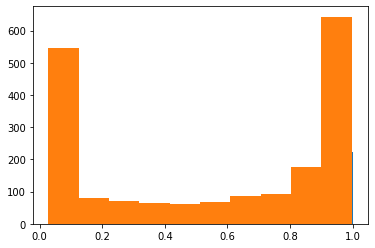

In [261]:
plt.hist(z1[true_indices].detach().numpy()) # false negatives
plt.hist(z1[false_indices].detach().numpy()) # true negatives

(array([776., 203., 106.,  89.,  64.,  50.,  61.,  58.,  65., 418.]),
 array([0.09772418, 0.18701683, 0.27630946, 0.3656021 , 0.45489478,
        0.5441874 , 0.6334801 , 0.7227727 , 0.81206536, 0.901358  ,
        0.99065065], dtype=float32),
 <BarContainer object of 10 artists>)

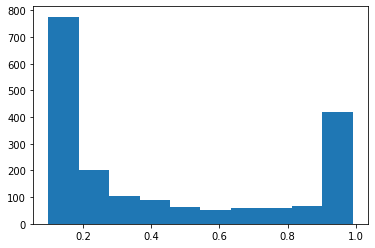

In [280]:
# plt.hist(z1[true_indices].detach().numpy()) # false negatives
plt.hist(z1[false_indices].detach().numpy()) # true negatives

(array([481., 119.,  88.,  67.,  68.,  51.,  51.,  47.,  77., 841.]),
 array([0.07469564, 0.16397032, 0.25324503, 0.3425197 , 0.43179438,
        0.52106905, 0.61034375, 0.69961846, 0.78889316, 0.8781678 ,
        0.9674425 ], dtype=float32),
 <BarContainer object of 10 artists>)

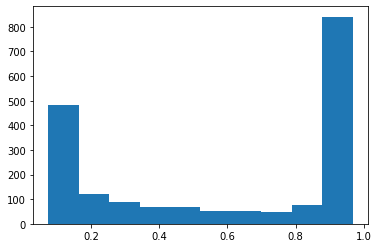

In [309]:
# plt.hist(z1[true_indices].detach().numpy()) # false negatives
plt.hist(z1[false_indices].detach().numpy()) # true negatives